<a href="https://colab.research.google.com/github/Adrian-Bulambao/CPE-313/blob/main/Hands_on_Activity_4_2_Transfer_Learning_on_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using PyTorch

Technological Institute of the Philippines | Quezon City - Computer Engineering
--- | ---
Course Code: | CPE 313
Code Title: | Advanced Machine Learning and Deep Learning
2nd Semester | AY 2025-2026
<u>**Hands-on Activity 4.2** | **Transfer Learning on PyTorch**
**Name** | Adrian Justin Bulambao
**Section** | CPE32S3
**Date Performed**: | February 19, 2026
**Date Submitted**: | Fenruary 19, 2026
**Instructor**: | Engr. Neal Barton James Matira


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Thu Feb 19 07:22:55 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load Important Libraries

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [ ]:
!rm -R /content/hymenoptera_data/train/.ipynb_checkpoints
!ls "/content/drive/MyDrive/Elective 3/hymenoptera_data/train" -a   #to make sure that the deletion has occurred

!rm -R /content/hymenoptera_data/val/.ipynb_checkpoints
!ls "/content/drive/MyDrive/Elective 3/hymenoptera_data/val" -a   #to make sure that the deletion has occurred

rm: cannot remove '/content/hymenoptera_data/train/.ipynb_checkpoints': No such file or directory
ants  bees
rm: cannot remove '/content/hymenoptera_data/val/.ipynb_checkpoints': No such file or directory
ants  bees


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Elective 3/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


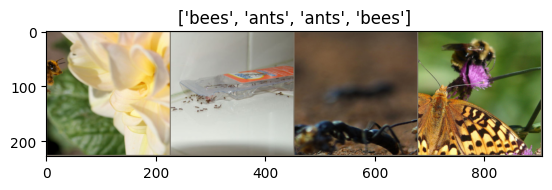

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7022 Acc: 0.6844
val Loss: 0.2009 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.6046 Acc: 0.7377
val Loss: 0.3625 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.5014 Acc: 0.7910
val Loss: 0.3458 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.5251 Acc: 0.8197
val Loss: 0.7205 Acc: 0.7712

Epoch 4/24
----------
train Loss: 0.4700 Acc: 0.8197
val Loss: 0.3947 Acc: 0.8366

Epoch 5/24
----------
train Loss: 0.4616 Acc: 0.8361
val Loss: 0.3816 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.4728 Acc: 0.8033
val Loss: 0.3822 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3407 Acc: 0.8770
val Loss: 0.2879 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.2547 Acc: 0.8934
val Loss: 0.2482 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3156 Acc: 0.8730
val Loss: 0.2662 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.3649 Acc: 0.8730
val Loss: 0.3088 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.3294 Acc: 0.8525
val Loss: 0.2799 Acc: 0.8954

Ep

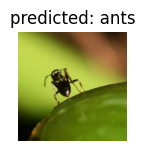

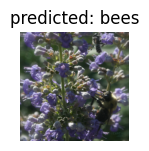

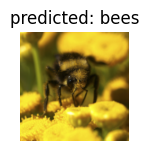

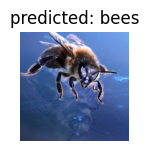

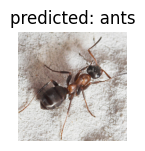

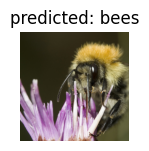

In [ ]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6054 Acc: 0.6680
val Loss: 0.2155 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.6634 Acc: 0.7459
val Loss: 0.1856 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.3971 Acc: 0.8238
val Loss: 0.1734 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3576 Acc: 0.8484
val Loss: 0.2228 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.5889 Acc: 0.7664
val Loss: 0.1909 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4485 Acc: 0.8115
val Loss: 0.2438 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4087 Acc: 0.7992
val Loss: 0.3887 Acc: 0.8431

Epoch 7/24
----------
train Loss: 0.4218 Acc: 0.8074
val Loss: 0.2107 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3331 Acc: 0.8566
val Loss: 0.2131 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3257 Acc: 0.8730
val Loss: 0.2302 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3331 Acc: 0.8648
val Loss: 0.2172 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3005 Acc: 0.8566
val Loss: 0.2074 Acc: 0.9346

Ep

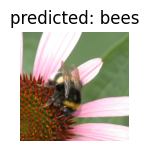

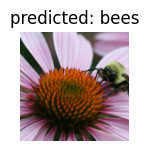

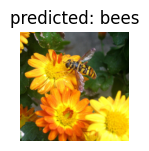

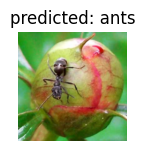

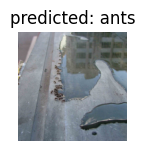

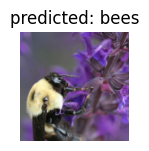

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

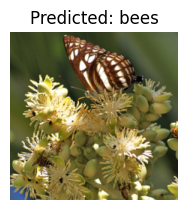

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/Elective 3/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## Further Learning
================

If you would like to learn more about the applications of transfer
learning, checkout the
* [Quantized Transfer Learning for Computer Vision
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).


# Supplementary Activity

In a new notebook, perform the following:
1. Choose a pretrained model.
2. Finetune on your dataset from the previous activity.
3. Evaluate the performance of the previous model to this finetuned model.

4. Utilize the pretrained ConvNet model as fixed feature extractor.
5. Evaluate the performance of the previous model to this finetuned model.

6.  Discuss the following:
  * How did finetuning affect your performance?
  * Which of the different situations for rule of thumb were applicable to you?

1. Choose a pretrained model.

2. Finetune on your dataset from the previous activity.

In [ ]:
model_goog = models.googlenet(weights='IMAGENET1K_V1')
num_ftrs = model_goog.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_goog.fc = nn.Linear(num_ftrs, 2)

model_goog = model_goog.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_goog.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_goog = train_model(model_goog, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.6034 Acc: 0.6516
val Loss: 0.3053 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4399 Acc: 0.7869
val Loss: 0.2363 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4393 Acc: 0.7582
val Loss: 0.2550 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.3436 Acc: 0.8607
val Loss: 0.2431 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3633 Acc: 0.8361
val Loss: 0.2719 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.3641 Acc: 0.8689
val Loss: 0.2236 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3581 Acc: 0.8770
val Loss: 0.1960 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3608 Acc: 0.8402
val Loss: 0.1861 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3044 Acc: 0.8689
val Loss: 0.1763 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2794 Acc: 0.8852
val Loss: 0.1734 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3577 Acc: 0.8238
val Loss: 0.1649 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2785 Acc: 0.8770
val Loss: 0.1858 Acc: 0.9412

Epoch 12/24
----------
t

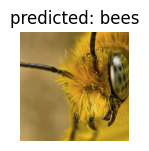

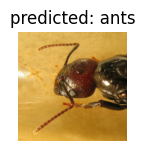

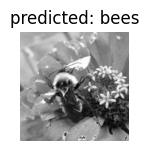

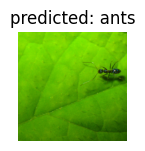

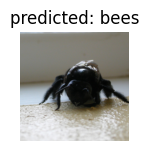

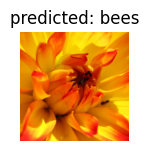

In [ ]:
visualize_model(model_goog)

3. Evaluate the performance of the previous model to this finetuned mode

    - The Google Net model was able to perform better than the resnet18, which is not often the case as resnet 18 is often better than googlenet. And from what I read, googlenet has 7 million parameters and resnet has 11 million, the huge amount of difference on the parameters may have had an impact to the accuracy, as the resnet may have overfitted in this dataset.

4. Utilize the pretrained ConvNet model as fixed feature extractor.

In [ ]:
model_goog2 = torchvision.models.googlenet(weights='IMAGENET1K_V1')
for param in model_goog2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_goog2.fc.in_features
model_goog2.fc = nn.Linear(num_ftrs, 2)

model_goog2 = model_goog2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_goog2.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_goog2 = train_model(model_goog2, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6005 Acc: 0.6721
val Loss: 0.3929 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4662 Acc: 0.7828
val Loss: 0.3186 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4895 Acc: 0.7705
val Loss: 0.2965 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.4784 Acc: 0.7746
val Loss: 0.2615 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4070 Acc: 0.8279
val Loss: 0.2184 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3924 Acc: 0.8156
val Loss: 0.2288 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3609 Acc: 0.8279
val Loss: 0.2728 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4417 Acc: 0.7746
val Loss: 0.2139 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3710 Acc: 0.8361
val Loss: 0.1979 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4655 Acc: 0.7746
val Loss: 0.2054 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3457 Acc: 0.8361
val Loss: 0.2119 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4052 Acc: 0.8361
val Loss: 0.1993 Acc: 0.9542

Ep

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


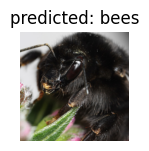

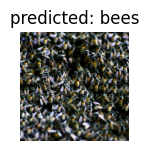

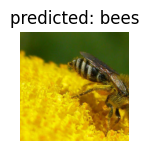

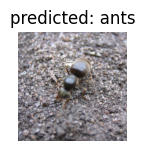

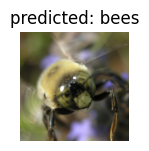

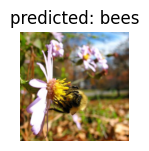

In [ ]:
visualize_model(model_goog2)

5. Evaluate the performance of the previous model to this finetuned model.
    - The performance of the finetuned model was also better than the resnet model and the same as the model when the ConvNet model wasn't used as a feature extractor.

6. Discuss the following:
- How did finetuning affect your performance?
  - Finetuning was helpful as it help in making the model perform better for this dataset.

- Which of the different situations for rule of thumb were applicable to you?
  - Making the learning rate as 0.001, I got a 95% accuracy, and I tried changing the learning rate to 0.003 and 0.0001 in order to try to increase the accuracy, however, I got the opposite, the model reached a 72% accuracy instead.


# Conclusion


From this activity I was able to perform transform learning which is using a pre-trained model and fine-tuning it to perform in a specific dataset. I was able to find a pre-trained model to use and got a 95% accuracy, however, in some models I got an error, as some of the models need a different kernel size as the kernel size of the model and the image are different, and I needed to change the kernel size of the mode, and from what I saw, in order to fix the error, I need to change the size of the image, or create the pre-trained model to a custom model. So instead, I just want with a different model in order to save myself time.